In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import seaborn as sns
import pandas as pd
pd.options.display.max_columns = None
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import cPickle as pickle
from IPython.display import Image
from util import *

In [2]:
train_df = pd.read_csv('../data/train_feat.csv')

In [3]:
X = train_df.drop(['building_id', 'blighted'], axis=1)
y = train_df['blighted']

In [4]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1027)

In [5]:
import xgboost as xgb

In [6]:
dm_train = xgb.DMatrix(X_train, y_train)
dm_eval = xgb.DMatrix(X_eval, y_eval)
watchlist = [(dm_eval, 'eval')]
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'eta': 0.05,
    'max_depth': 5,
    'seed': 1027,
    'silent': 0,
    'eval_metric': 'auc'
}

In [7]:
clf = xgb.train(params, dm_train, 500, watchlist, early_stopping_rounds=20)

In [8]:
y_pred_proba = clf.predict(dm_eval, ntree_limit=clf.best_ntree_limit)

In [9]:
round(roc_auc_score(y_eval, y_pred_proba), 5)

0.85707

**Better than 0.83157 obtained by Random Forest**

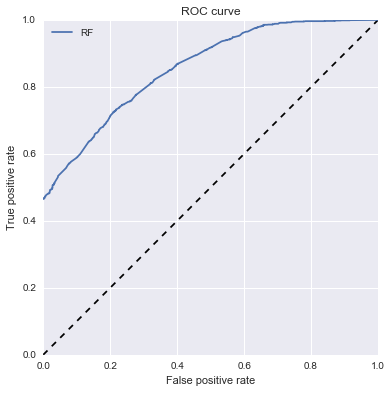

In [11]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba, pos_label=1)
plt.figure(figsize=(6, 6), dpi=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [12]:
feat_imp = [(k, v) for (k, v) in clf.get_fscore().iteritems()]
feat_imp_top10 = sorted(feat_imp, key=lambda x: x[1], reverse=True)[:10]

In [13]:
feat_names, feat_imps = zip(*feat_imp_top10)

In [14]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)

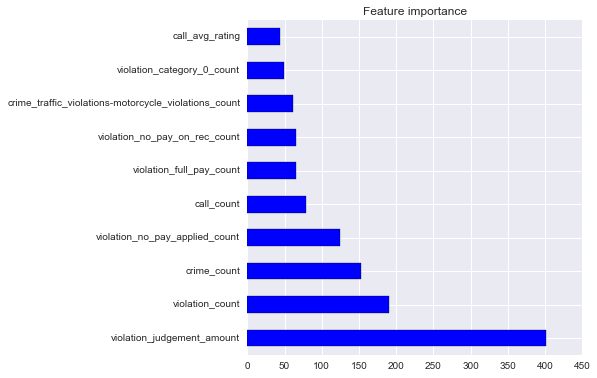

In [15]:
plt.figure(figsize=(6, 6), dpi=None)
feat_imp_vis.plot(kind='barh', title='Feature importance')

## Let's try simple features and limt maximum depth to 4

In [16]:
X2 = train_df[['violation_judgement_amount', 'violation_count', 'crime_count', 'call_count']]
y2 = train_df['blighted']

In [17]:
X2_train, X2_eval, y2_train, y2_eval = train_test_split(X2, y2, test_size=0.3, stratify = y, random_state=1027)

In [49]:
dm_train2 = xgb.DMatrix(X2_train, y2_train)
dm_eval2 = xgb.DMatrix(X2_eval, y2_eval)
watchlist2 = [(dm_eval2, 'eval')]
params2 = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'subsample': 0.8,
    'colsample_bytree': 0.85,
    'eta': 0.05,
    'max_depth': 4,
    'seed': 1027,
    'silent': 0,
    'eval_metric': 'auc'
}

In [50]:
clf2 = xgb.train(params2, dm_train2, 500, watchlist2, early_stopping_rounds=20)

In [51]:
y2_pred_proba = clf2.predict(dm_eval2, ntree_limit=clf2.best_ntree_limit)

In [52]:
round(roc_auc_score(y2_eval, y2_pred_proba), 5)

0.85234

**Less than 0.005 decrease in AUC score, huge increase in model simplicity and interpretability.**

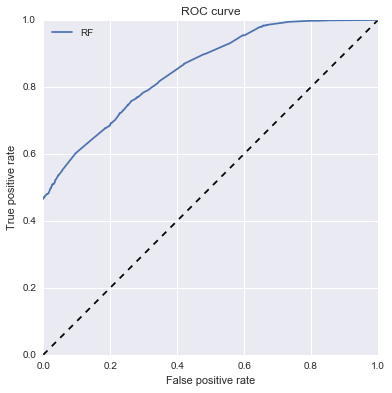

In [53]:
fpr2, tpr2, thresholds2 = roc_curve(y2_eval, y2_pred_proba, pos_label=1)
plt.figure(figsize=(6, 6), dpi=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Let's plot the decision tree

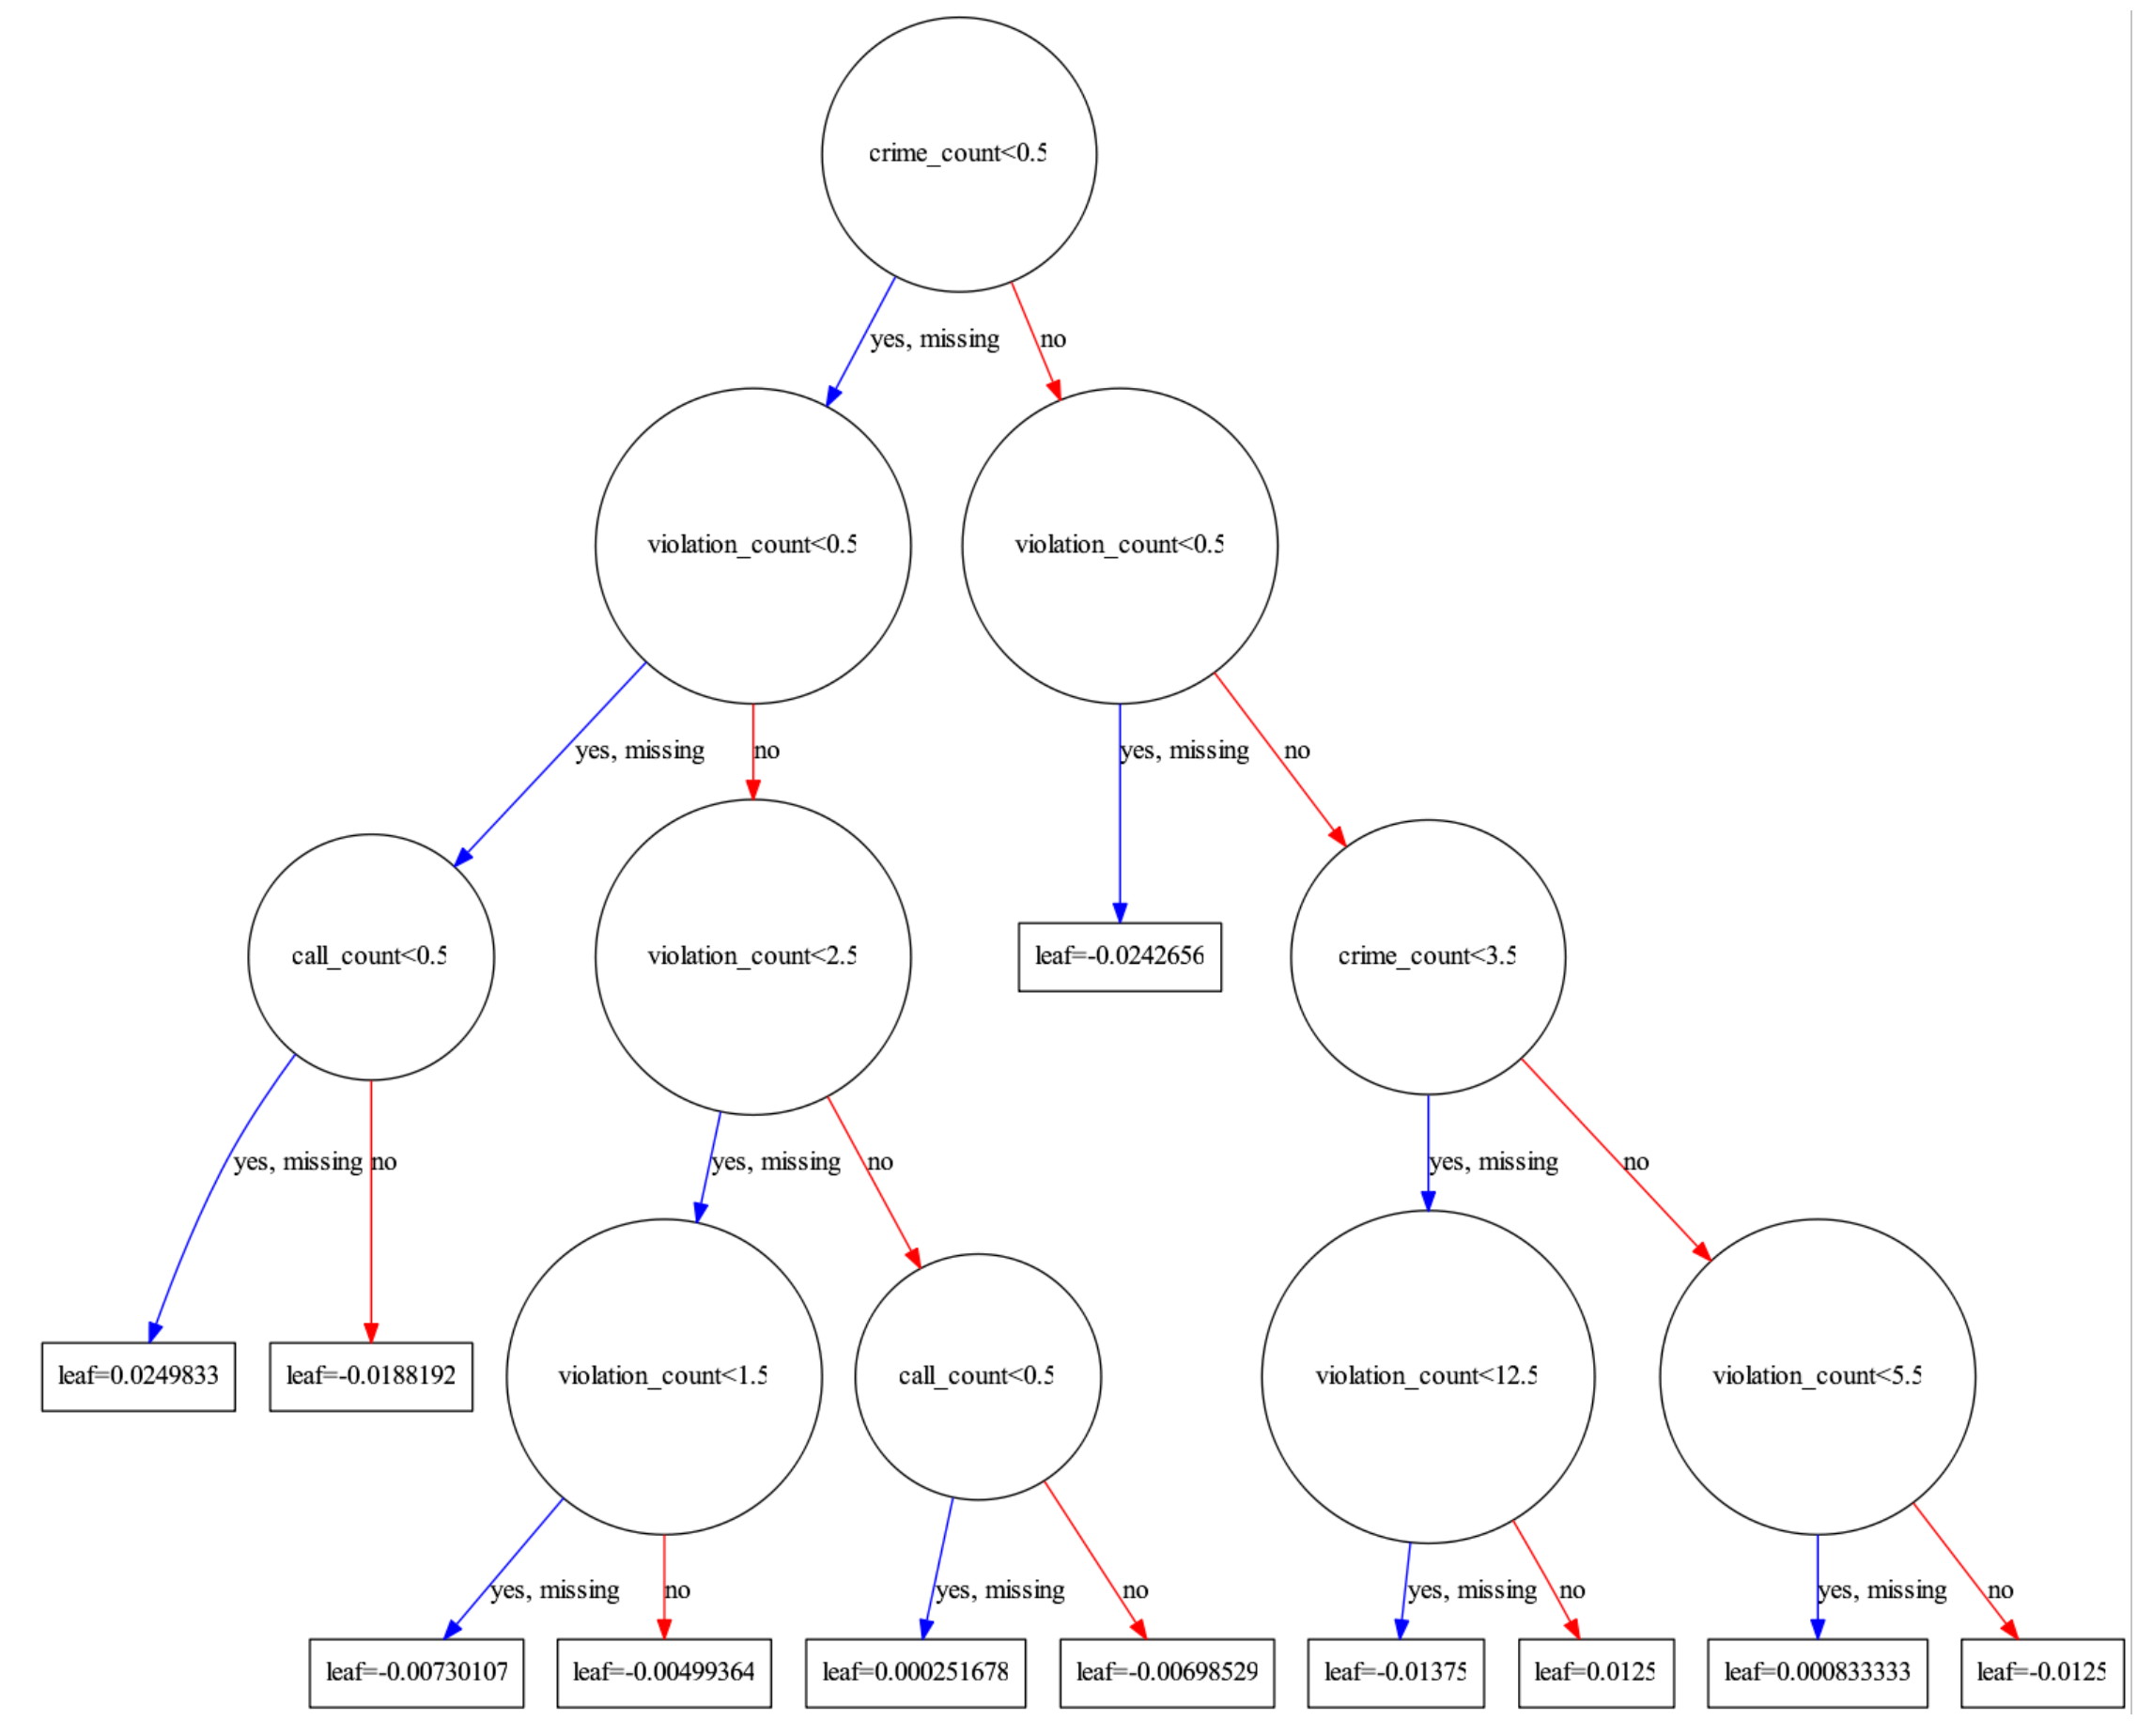

In [63]:
fig, ax = plt.subplots(figsize=(40, 40))
xgb.plot_tree(clf2, num_trees=0, ax=ax)

## Explore out-of-sample data

### Load out-of-sample data and predict

In [106]:
oos_df = pd.read_csv('../data/oos_feat.csv')

In [108]:
T = oos_df[['violation_judgement_amount', 'violation_count', 'crime_count', 'call_count']]

In [109]:
dm_test = xgb.DMatrix(T)

In [110]:
t_pred_proba = clf2.predict(dm_test, ntree_limit=clf2.best_ntree_limit)

In [114]:
oos_pred_df = pd.DataFrame()

{'boxes': [<matplotlib.lines.Line2D at 0x14acec50>],
 'caps': [<matplotlib.lines.Line2D at 0x120ccb38>,
 'fliers': [<matplotlib.lines.Line2D at 0x14a02c88>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x14a02710>],
 'whiskers': [<matplotlib.lines.Line2D at 0x14ace9b0>,
  <matplotlib.lines.Line2D at 0x148605f8>]}

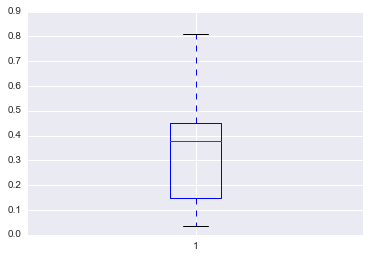

In [113]:
plt.boxplot(t_pred_proba)

**Looks like most buildings are not in risk of blight. (assuming a threshold around 0.5)**

### Obtain a data frame with building info and predicted score for visualization

In [115]:
oos_pred_df['building_id'] = oos_df['building_id']
oos_pred_df['score'] = t_pred_proba

In [117]:
buildings = pd.read_csv('../data/buildings.csv')

In [119]:
oos_vis_df = pd.merge(oos_pred_df, buildings, on='building_id', how='left')

In [121]:
oos_vis_df.head(3)

,building_id,score,bottom_left,top_right,addr,cluster,num,incident_ids
0,0,0.274474,"[42.255267050999997, -83.161064993999986]","[42.255811, -83.16050500000001]",26585 OUTER DRIVE,0,2,"[53453.0, 446027.0]"
1,1,0.225805,"[42.256026999999996, -83.1607722]","[42.256177, -83.1606222]",3808 S Bassett St,1,1,[446640.0]
2,2,0.225805,"[42.256281200000004, -83.160299]","[42.25643120000001, -83.160149]",3795 S. Bassett,2,1,[446574.0]


In [122]:
oos_vis_df.to_csv('../data/oos_vis.csv')